In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
pd.set_option('max_rows', 5)
%matplotlib inline

## 独立性の検定
---
2 変数が独立だとした場合の期待度数から実際の観測度数がどれくらい外れているかに基づいて検定を行う。

### 周辺化
---
分割表で行または列方向にデータ数や確率などを集計することを周辺化という。  
周辺化されたデータ数・確率をそれぞれ周辺度数・周辺確率と呼ぶ。

<table class="text-center border background-default">
    <tr>
        <td class="border-none" colspan="5">周辺度数</td>
    </tr>
    <tr>
        <td class="border-none" rowspan="2" colspan="2"></td>
        <td colspan="2">変数 $X$</td>
        <th class="background-dark" rowspan="2">周辺度数</th>
    </tr>
    <tr>
        <td class="border-bottom-bold" style="min-width: 6.5em;">カテゴリ $X_{1}$</td>
        <td class="border-bottom-bold" style="min-width: 6.5em;">カテゴリ $X_{2}$</td>
    </tr>
    <tr>
        <td rowspan="2">変数 $Y$</td>
        <td class="border-right-bold">カテゴリ $Y_{1}$</td>
        <td>$a$</td>
        <td>$b$</td>
        <td class="background-dark">$a+b$</td>
    </tr>
    <tr>
        <td class="border-right-bold">カテゴリ $Y_{2}$</td>
        <td>$c$</td>
        <td>$d$</td>
        <td class="background-dark">$c+d$</td>
    </tr>
    <tr class="background-dark">
        <th class="border-bottom border-right-bold" colspan="2">周辺度数</th>
        <td>$a+c$</td>
        <td>$b+d$</td>
    </tr>
</table>

<table class="text-center border background-default">
    <tr>
        <td class="border-none" colspan="5">周辺確率</td>
    </tr>
    <tr>
        <td class="border-none" rowspan="2" colspan="2"></td>
        <td colspan="2">変数 $X$</td>
        <th class="background-dark" rowspan="2">周辺確率</th>
    </tr>
    <tr>
        <td class="border-bottom-bold" style="min-width: 6.5em;">カテゴリ $X_{1}$</td>
        <td class="border-bottom-bold" style="min-width: 6.5em;">カテゴリ $X_{2}$</td>
    </tr>
    <tr>
        <td rowspan="2">変数 $Y$</td>
        <td class="border-right-bold">カテゴリ $Y_{1}$</td>
        <td>$p(X_{1},Y{1})$</td>
        <td>$p(X_{2},Y_{1})$</td>
        <td class="background-dark">$p(Y_{1})$</td>
    </tr>
    <tr>
        <td class="border-right-bold">カテゴリ $Y_{2}$</td>
        <td>$p(X_{1},Y{2})$</td>
        <td>$p(X_{2},Y_{2})$</td>
        <td class="background-dark">$p(Y_{2})$</td>
    </tr>
    <tr class="background-dark">
        <th class="border-bottom border-right-bold" colspan="2">周辺確率</th>
        <td>$p(X_{1})$</td>
        <td>$p(X_{2})$</td>
    </tr>
</table>

###### 練習問題

`titanic`データセットを行方向に`Survived`、列方向に`Class`をとって各セルが度数になっているものと確率 (= 全体に占める割合) になっているもの 2 種類の分割表を作成し、周辺度数・周辺確率を求める。

In [2]:
titanic = pd.read_csv('data/Titanic.csv')
print('titanic')
display(titanic)

titanic


,Class,Sex,Age,Survived
1,3rd,Male,Child,No
2,3rd,Male,Child,No
...,...,...,...,...
2200,Crew,Female,Adult,Yes
2201,Crew,Female,Adult,Yes


In [3]:
pd.crosstab(titanic['Survived'], titanic['Class'], margins=True)

Class,1st,2nd,3rd,Crew,All
Survived,,,,,
No,122,167,528,673,1490
Yes,203,118,178,212,711
All,325,285,706,885,2201


In [4]:
pd.crosstab(titanic['Survived'], titanic['Class'], margins=True, normalize=True)

Class,1st,2nd,3rd,Crew,All
Survived,,,,,
No,0.055429,0.075875,0.239891,0.30577,0.676965
Yes,0.092231,0.053612,0.080872,0.09632,0.323035
All,0.147660,0.129487,0.320763,0.40209,1.000000


### 確率的独立
---
確率変数 $X,Y$ について、 $X$ の値が高ければ $Y$ の値も高くなるなどの関係がなく、互いの値に無関係にそれぞれの値が決まることを独立という。  
これは $p( x|y) =p( x) ,p( y|x) =p( y)$ ということであり、このとき $x,y$ の同時確率 (その値が同時に得られる確率) はそれぞれの確率の積になる。

$$
\begin{align}
    p( X,Y) & =p( X|Y) p( Y)\\
     & \\
     & =p( X) p( Y)
\end{align}
$$

### 期待度数
---
2 変数が独立であるとした場合の各セルの度数の期待値。  
セル $X_{i},Y_{j}$ の観測度数を $O_{ij}$ とすると期待度数 $E_{ij}$ は以下のように表される。

<table class="text-center border background-default">
    <tr>
        <td class="border-none" colspan="7">度数</td>
    </tr>
    <tr>
        <td class="border-none" rowspan="2" colspan="2"></td>
        <td colspan="4">変数 $X$</td>
        <td class="border-bottom-bold" rowspan="2" style="min-width: 16em;">周辺度数</td>
    </tr>
    <tr>
        <td class="border-bottom-bold" style="min-width: 11.5em;">カテゴリ $X_{1}$</td>
        <td class="border-bottom-bold" style="min-width: 11.5em;">カテゴリ $X_{2}$</td>
        <td class="border-bottom-bold">$\cdots$</td>
        <td class="border-bottom-bold" style="min-width: 11.5em;">カテゴリ $X_{k}$</td>
    </tr>
    <tr>
        <td rowspan="4">変数 $Y$</td>
        <td class="border-right-bold">カテゴリ $Y_{1}$</td>
        <td>$O_{11}$</td>
        <td>$O_{21}$</td>
        <td>$\cdots$</td>
        <td>$O_{k1}$</td>
        <td>$\displaystyle \sum ^{k}_{i=1} O_{i1}$</td>
    </tr>
    <tr>
        <td class="border-right-bold">カテゴリ $Y_{2}$</td>
        <td>$O_{12}$</td>
        <td>$O_{22}$</td>
        <td></td>
        <td>$O_{k2}$</td>
        <td>$\displaystyle \sum ^{k}_{i=1} O_{i2}$</td>
    </tr>
    <tr>
        <td class="border-right-bold">$\vdots$</td>
        <td>$\vdots$</td>
        <td></td>
        <td>$\ddots$</td>
        <td>$\vdots$</td>
        <td>$\vdots$</td>
    </tr>
    <tr>
        <td class="border-right-bold">カテゴリ $Y_{l}$</td>
        <td>$O_{1l}$</td>
        <td>$O_{2l}$</td>
        <td>$\cdots$</td>
        <td>$O_{kl}$</td>
        <td>$\displaystyle \sum ^{k}_{i=1} O_{il}$</td>
    </tr>
    <tr>
        <td class="border-right-bold" colspan="2">周辺度数</td>
        <td>$\displaystyle \sum ^{l}_{j=1} O_{1j}$</td>
        <td>$\displaystyle \sum ^{l}_{j=1} O_{2j}$</td>
        <td>$\cdots$</td>
        <td>$\displaystyle \sum ^{l}_{j=1} O_{kj}$</td>
        <td>$\displaystyle N=\sum ^{k}_{i=1}\sum ^{l}_{j=1} O_{ij}$</td>
    </tr>
</table>

<table class="text-center border background-default">
    <tr>
        <td class="border-none" colspan="7">確率</td>
    </tr>
    <tr>
        <td class="border-none" rowspan="2" colspan="2"></td>
        <td colspan="4">変数 $X$</td>
        <td class="border-bottom-bold" rowspan="2" style="min-width: 16em;">周辺確率</td>
    </tr>
    <tr>
        <td class="border-bottom-bold" style="min-width: 11.5em;">カテゴリ $X_{1}$</td>
        <td class="border-bottom-bold" style="min-width: 11.5em;">カテゴリ $X_{2}$</td>
        <td class="border-bottom-bold">$\cdots$</td>
        <td class="border-bottom-bold" style="min-width: 11.5em;">カテゴリ $X_{k}$</td>
    </tr>
    <tr>
        <td rowspan="4">変数 $Y$</td>
        <td class="border-right-bold">カテゴリ $Y_{1}$</td>
        <td>$p(X_{1},Y_{1})$</td>
        <td>$p(X_{2},Y_{1})$</td>
        <td>$\cdots$</td>
        <td>$p(X_{k},Y_{1})$</td>
        <td>$\displaystyle p( Y_{1}) =\frac{\sum ^{k}_{i=1} O_{i1}}{N}$</td>
    </tr>
    <tr>
        <td class="border-right-bold">カテゴリ $Y_{2}$</td>
        <td>$p(X_{1},Y_{2})$</td>
        <td>$p(X_{2},Y_{2})$</td>
        <td>$\cdots$</td>
        <td>$p(X_{k},Y_{2})$</td>
        <td>$\displaystyle p( Y_{2}) =\frac{\sum ^{k}_{i=1} O_{i2}}{N}$</td>
    </tr>
    <tr>
        <td class="border-right-bold">$\vdots$</td>
        <td>$\vdots$</td>
        <td></td>
        <td>$\ddots$</td>
        <td>$\vdots$</td>
        <td>$\vdots$</td>
    </tr>
    <tr>
        <td class="border-right-bold">カテゴリ $Y_{l}$</td>
        <td>$p(X_{1},Y_{l})$</td>
        <td>$p(X_{2},Y_{l})$</td>
        <td>$\cdots$</td>
        <td>$p(X_{k},Y_{l})$</td>
        <td>$\displaystyle p( Y_{l}) =\frac{\sum ^{k}_{i=1} O_{il}}{N}$</td>
    </tr>
    <tr>
        <td class="border-right-bold" colspan="2">周辺確率</td>
        <td>$\displaystyle p( X_{1}) =\frac{\sum ^{l}_{j=1} O_{1j}}{N}$</td>
        <td>$\displaystyle p( X_{2}) =\frac{\sum ^{l}_{j=1} O_{2j}}{N}$</td>
        <td>$\cdots$</td>
        <td>$\displaystyle p( X_{k}) =\frac{\sum ^{l}_{j=1} O_{kj}}{N}$</td>
        <td>$\displaystyle \sum ^{k}_{i=1} p( X_{i}) =\sum ^{l}_{j=1} p( Y_{j}) =1$</td>
    </tr>
</table>

<table class="text-center border background-default">
    <tr>
        <td class="border-none" colspan="7">期待度数</td>
    </tr>
    <tr>
        <td class="border-none" rowspan="2" colspan="2"></td>
        <td colspan="4">変数 $X$</td>
        <td class="border-bottom-bold" rowspan="2" style="min-width: 16em;">周辺度数</td>
    </tr>
    <tr>
        <td class="border-bottom-bold" style="min-width: 11.5em;">カテゴリ $X_{1}$</td>
        <td class="border-bottom-bold" style="min-width: 11.5em;">カテゴリ $X_{2}$</td>
        <td class="border-bottom-bold">$\cdots$</td>
        <td class="border-bottom-bold" style="min-width: 11.5em;">カテゴリ $X_{k}$</td>
    </tr>
    <tr>
        <td rowspan="4">変数 $Y$</td>
        <td class="border-right-bold">カテゴリ $Y_{1}$</td>
        <td>$\displaystyle E_{11}=Np( X_{1}) p( Y_{1})$</td>
        <td>$\displaystyle E_{21}=Np( X_{2}) p( Y_{1})$</td>
        <td>$\cdots$</td>
        <td>$\displaystyle E_{k1}=Np( X_{k}) p( Y_{1})$</td>
        <td>$\displaystyle Np(Y_{1})=\sum ^{k}_{i=1} O_{i1}$</td>
    </tr>
    <tr>
        <td class="border-right-bold">カテゴリ $Y_{2}$</td>
        <td>$\displaystyle E_{12}=Np( X_{1}) p( Y_{2})$</td>
        <td>$\displaystyle E_{22}=Np( X_{2}) p( Y_{2})$</td>
        <td>$\cdots$</td>
        <td>$\displaystyle E_{k2}=Np( X_{k}) p( Y_{2})$</td>
        <td>$\displaystyle Np(Y_{2})=\sum ^{k}_{i=1} O_{i2}$</td>
    </tr>
    <tr>
        <td class="border-right-bold">$\vdots$</td>
        <td>$\vdots$</td>
        <td></td>
        <td>$\ddots$</td>
        <td>$\vdots$</td>
        <td>$\vdots$</td>
    </tr>
    <tr>
        <td class="border-right-bold">カテゴリ $Y_{l}$</td>
        <td>$\displaystyle E_{1l}=Np( X_{1}) p( Y_{l})$</td>
        <td>$\displaystyle E_{2l}=Np( X_{2}) p( Y_{l})$</td>
        <td>$\cdots$</td>
        <td>$\displaystyle E_{kl}=Np( X_{k}) p( Y_{l})$</td>
        <td>$\displaystyle Np(Y_{l})=\sum ^{k}_{i=1} O_{il}$</td>
    </tr>
    <tr>
        <td class="border-right-bold" colspan="2">周辺度数</td>
        <td>$\displaystyle Np(X_{1})=\sum ^{l}_{j=1} O_{1j}$</td>
        <td>$\displaystyle Np(X_{2})=\sum ^{l}_{j=1} O_{2j}$</td>
        <td>$\cdots$</td>
        <td>$\displaystyle Np(X_{k})=\sum ^{l}_{j=1} O_{kj}$</td>
        <td>$\displaystyle \sum ^{k}_{i=1} Np( X_{i}) =\sum ^{l}_{j=1} Np( Y_{j}) =N$</td>
    </tr>
</table>

### カイ二乗検定
---
統計量 $\displaystyle \chi ^{2} =\sum ^{k}_{i=1}\sum ^{l}_{j=1}\frac{( O_{ij} -E_{ij})^{2}}{E_{ij}}$ が近似的に自由度 $(k-1)(l-1)$ の[カイ二乗分布](../beginner/population_mean_estimation.ipynb#$\chi^2$-(%E3%82%AB%E3%82%A4%E4%BA%8C%E4%B9%97)-%E5%88%86%E5%B8%83)に従うことを利用して検定する。  
自由度 $n-1$ のカイ二乗分布は $\displaystyle X_{i} \sim \mathcal{N}\left( \mu _{i} ,\sigma ^{2}_{i}\right) ,Z_{i} =\frac{X_{i} -\mu _{i}}{\sigma _{i}}$ とすると、 $\displaystyle \sum ^{n}_{i=1} Z^{2}_{i} =\sum ^{n}_{i=1}\frac{( X_{i} -\mu _{i})^{2}}{\sigma ^{2}_{i}}$ が従う分布。  
二乗しているので、**常に両側検定**になる。

### 注意点

#### 2×2分割表の場合
---
$2\times 2$ 分割表の場合には、対角の積 $
\displaystyle ( O_{11} O_{22} ,O_{12} O_{21})
$ と周辺度数 $
\displaystyle \left(\sum ^{2}_{i=1} O_{i1} ,\sum ^{2}_{i=1} O_{i2} ,\sum ^{2}_{j=1} O_{1j} ,\sum ^{2}_{j=1} O_{2j}\right)
$ を使って $
\displaystyle \chi ^{2} =\frac
    {N( O_{12} O_{21} -O_{11} O_{22})^{2}}
    {\displaystyle \sum ^{2}_{i=1} O_{i1}\sum ^{2}_{i=1} O_{i2}\sum ^{2}_{j=1} O_{1j}\sum ^{2}_{j=1} O_{2j}}
$ と表せる。 (下記参照)

このとき、近似の精度が悪いのでイェーツの補正と呼ばれる修正を行った以下の値を検定統計量として使用する。

$$
\displaystyle \chi ^{2} =\frac
    {N\left(\displaystyle |O_{12} O_{21} -O_{11} O_{22} |-\frac
        {N}
        {2}
    \right)^{2}}
    {\displaystyle \sum ^{2}_{i=1} O_{i1}\sum ^{2}_{i=1} O_{i2}\sum ^{2}_{j=1} O_{1j}\sum ^{2}_{j=1} O_{2j}}
$$

###### 参考

$$
\begin{align}
    \chi ^{2} & =\sum ^{2}_{i=1}\sum ^{2}_{j=1}\frac
        {( O_{ij} -E_{ij})^{2}}
        {E_{iJ}}\\
     & \\
     & =\displaystyle \sum ^{2}_{i=1}\sum ^{2}_{j=1}\frac
         {\left( \displaystyle O_{ij} -\frac
             {\displaystyle \sum ^{2}_{l=1} O_{il}\sum ^{2}_{k=1} O_{kj}}
             {N}
         \right)^{2}}
         {\displaystyle \frac
             {\displaystyle \sum ^{2}_{l=1} O_{il}\sum ^{2}_{k=1} O_{kj}}
             {N}
         }\\
     & \\
     & =\displaystyle \frac
         {1}
         {N}
     \sum ^{2}_{i=1}\sum ^{2}_{j=1}\frac
         {{\displaystyle \left( NO_{ij} -\sum ^{2}_{l=1} O_{il}\sum ^{2}_{k=1} O_{kj}\right)^{2}}}
         {{\displaystyle \sum ^{2}_{l=1} O_{il}\sum ^{2}_{k=1} O_{kj}}}\\
     & \\
     & =\displaystyle \frac
         {1}
         {N}
     \sum ^{2}_{i=1}\sum ^{2}_{j=1}\frac
         {( NO_{ij} -( O_{i1} +O_{i2})( O_{1j} +O_{2j}))^{2}}
         {\displaystyle \sum ^{2}_{l=1} O_{il}\sum ^{2}_{k=1} O_{kj}}\\
     & \\
     & =\displaystyle \frac
         {1}
         {N}
     \left(\frac
         {( O_{12} O_{21} -O_{11} O_{22})^{2}}
         {( O_{11} +O_{12})( O_{11} +O_{21})}
     +\frac
         {( O_{12} O_{21} -O_{11} O_{22})^{2}}
         {( O_{21} +O_{22})( O_{11} +O_{21})}
     +\frac
         {( O_{12} O_{21} -O_{11} O_{22})^{2}}
         {( O_{11} +O_{12})( O_{12} +O_{22})}
     +\frac
         {( O_{12} O_{21} -O_{11} O_{22})^{2}}
         {( O_{21} +O_{22})( O_{12} +O_{22})}
     \right)\\
     & \\
     & =\displaystyle \frac
         {N^{2}( O_{12} O_{21} -O_{11} O_{22})^{2}}
         {N( O_{11} +O_{12})( O_{11} +O_{21})( O_{21} +O_{22})( O_{12} +O_{22})}\\
     & \\
     & =\displaystyle \frac
         {N( O_{12} O_{21} -O_{11} O_{22})^{2}}
         {\displaystyle \sum ^{2}_{i=1} O_{i1}\sum ^{2}_{i=1} O_{i2}\sum ^{2}_{j=1} O_{1j}\sum ^{2}_{j=1} O_{2j}}
\end{align}
$$

#### 期待度数・サンプルサイズが小さい場合
---
カイ二乗検定は近似を用いるため、以下の場合には近似の精度が悪く使用すべきでない。

- サンプルサイズ $N$ が 20 以下
- 期待度数 5 以下のセルが全体の 20% 以上ある
- 期待度数 1 以下のセルが 1 つでもある

以上の場合にはフィッシャーの正確確率検定など他の手段を検討する。

###### 練習問題

`titanic`データセットの`Class`と`Survived`を基準に分割表を作成する。

In [5]:
titanic = pd.read_csv('data/Titanic.csv')
print('titanic')
display(titanic)

titanic


,Class,Sex,Age,Survived
1,3rd,Male,Child,No
2,3rd,Male,Child,No
...,...,...,...,...
2200,Crew,Female,Adult,Yes
2201,Crew,Female,Adult,Yes


In [6]:
cross = pd.crosstab(titanic['Class'], titanic['Survived'])
cross

Survived,No,Yes
Class,,
1st,122,203
2nd,167,118
3rd,528,178
Crew,673,212


###### 練習問題

上で作成した分割表を基に 2 変数`Class`と`Survived`が独立かどうかを検定するための統計量 $\chi ^{2}$ を求める。

In [7]:
E = stats.contingency.expected_freq(cross)
chi2 = ((cross - E) ** 2 / E).values.sum()
chi2

190.40110361683327

###### 練習問題

この検定に対応する帰無分布の確率密度関数と、上で求めた $\chi ^{2}$ 統計量の位置をグラフ表示する。

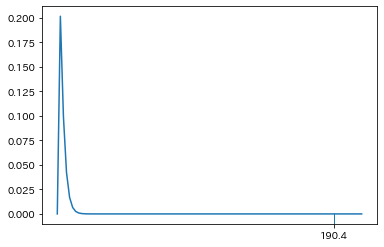

In [8]:
x = np.linspace(0, chi2 * 1.1, 100)
df = (cross.index.size - 1) * (cross.columns.size - 1)
null_dist = stats.chi2(df)
plt.plot(x, null_dist.pdf(x))
sns.rugplot([chi2])
plt.xticks([chi2])
plt.show()

###### 練習問題

上で求めた検定統計量 $\chi ^{2}$ に対応した $p$ 値を求める。

In [9]:
null_dist.sf(chi2)

4.999927529868003e-41

### Pythonでのカイ二乗検定の実行方法
---
`scipy.stats.chi2_contingency`や`statsmodels.stats.Table.test_nominal_association`を使用する。

In [10]:
stats.chi2_contingency??

In [11]:
stats.chi2_contingency(cross)

(190.40110361683327,
 4.999927529868003e-41,
 3,
 array([[220.01363017, 104.98636983],
        [192.93502953,  92.06497047],
        [477.93730123, 228.06269877],
        [599.11403907, 285.88596093]]))

In [12]:
sm.stats.Table.test_nominal_association??

In [13]:
print(sm.stats.Table(cross).test_nominal_association())

df          3
pvalue      0.0
statistic   190.4011036168333


## フィッシャーの正確確率検定
---
$2\times 2$ 分割表において、超幾何分布に基づいて検定を行う。

### 超幾何分布 (hypergeometric distribution)

###### 練習問題

赤・白の 2 種類の玉がそれぞれ 4 個・ 6 個入っている袋がある。ここから 5 個の玉を取り出した (袋に戻さずに 5 回玉を取り出した) ときに赤玉の含まれる個数を記録する。これを 10,000 回繰り返した結果をシミュレーションし、確率分布をグラフで表現する。

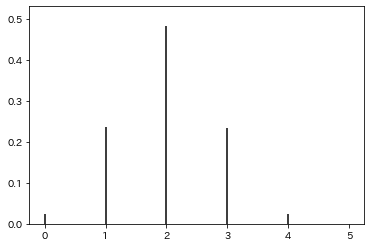

In [14]:
np.random.seed(1234)
sample = 5
reputation = int(1e4)
counts = np.arange(sample + 1)
bag = [1] * 4 + [0] * 6
data = [
    np.random.choice(bag, 5, replace=False).sum() for _ in range(reputation)
]
probs = [np.sum(data == c) / reputation for c in counts]
plt.vlines(counts, 0, probs)
plt.ylim((0, max(probs) * 1.1))
plt.show()

> 2 種類のものが混じった有限の母集団から非復元抽出 (一度取り出したものを戻さない抽出) を行ったときの一方 (成功) の個数の確率分布を超幾何分布という。

In [15]:
from helpers.crosstab_test import hypergeometric
hypergeometric.show()

interactive(children=(IntSlider(value=10, continuous_update=False, description='総数', max=15, min=2), IntSlider…

総数 $N$ 、対象の個数 $K$ 、抽出数を $n$ とすると、超幾何分布の確率質量関数 (抽出した中に $x$ 個の対象が含まれる確率) は以下で表される。

$$\displaystyle p=\frac{_{K} C_{x} \cdot _{N-K} C_{n-x}}{_{N} C_{n}}$$

### 超幾何分布と他の確率分布との関係
---
超幾何分布は有限母集団からの非復元抽出だが、復元抽出の場合 (無限母集団と考えても同様) は二項分布。  
総数 $N$ が大きいときには超幾何分布は二項分布 $\displaystyle Bi\left(n,\frac{K}{N}\right)$ で近似可能。また、二項分布と同様に $n$ が大きい場合で、期待値 $\displaystyle \frac{nK}{N}$ が小さいときにはポアソン分布、大きいときには正規分布で近似可能。

#### 超幾何分布の使用例
---
動物の生息数や漁業資源量などを推定する標識・再捕獲法に超幾何分布は使用可能。  
まず $K$ 頭の動物を捕獲し、標識 (目印) をつけてから自然に放つ。時間をおいて再度 $n$ 頭を捕獲する。このとき $x$ 頭の標識のついた動物が含まれていると、全体の生息数 $\displaystyle N=\frac{Kn}{x}$ と推定できるが、この推定の精度を超幾何分布から求める。 (実際には $N$ が大きく計算が大変なので他の確率分布で近似したほうがよい)

###### 練習問題

10 匹の魚を捕獲し、標識をつけて湖に放ち、時間をおいて再度 10 匹を捕獲したところ、標識のついた魚が 2 匹含まれていた。  
このとき、総数 $N$ を最小値から 2000 まで変化させたときの上の結果が得られる確率を格納した配列`probs`を作成し、折れ線グラフで表示する。

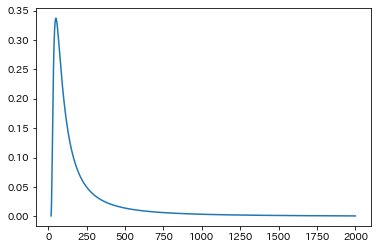

In [16]:
K = 10
n = 10
x = 2
N_min = K + n - x
N = N_min
probs = [stats.hypergeom(N, K, n).pmf(x) for N in range(N_min, 2001)]
NN = np.arange(len(probs)) + N_min
plt.plot(NN, probs)
plt.show()

###### 練習問題

上で作成した`probs`の $100\%$ 積み上げ折れ線グラフを表示する。 (積み上げた結果の値は配列`cumsum`に格納)

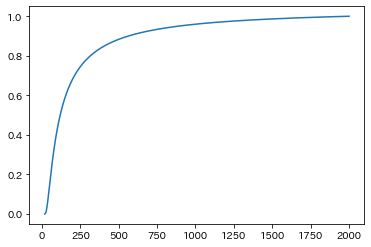

In [17]:
cumsum = np.cumsum(probs)
cumsum /= cumsum[-1]
plt.plot(NN, cumsum)
plt.show()

###### 練習問題

この標識・再捕獲法の推定量の $95\%$ 信頼区間の概算値 (`cumsum`の $2.5\%$ ・$97.5\%$ に対応する総数 $N$) を求める。 (区間内に含まれる最小・最大の整数でよい)

In [18]:
(NN[cumsum >= 0.025][0], NN[cumsum <= 0.975][-1])

(31, 1235)

### フィッシャーの正確確率検定 (Fisher's exact test)
---
以下のような分割表を考える。

<table class="text-center border background-default">
    <tr>
        <td class="border-none" rowspan="2" colspan="2"></td>
        <td colspan="2">変数 $X$</td>
        <td class="border-bottom-bold" rowspan="2">周辺度数</td>
    </tr>
    <tr>
        <td class="border-bottom-bold" style="min-width: 6.5em;">カテゴリ $X_{1}$</td>
        <td class="border-bottom-bold" style="min-width: 6.5em;">カテゴリ $X_{2}$</td>
    </tr>
    <tr>
        <td rowspan="2">変数 $Y$</td>
        <td class="border-right-bold">カテゴリ $Y_{1}$</td>
        <td>$a$</td>
        <td>$b$</td>
        <td>$a+b$</td>
    </tr>
    <tr>
        <td class="border-right-bold">カテゴリ $Y_{2}$</td>
        <td>$c$</td>
        <td>$d$</td>
        <td>$c+d$</td>
    </tr>
    <tr>
        <td class="border-right-bold" colspan="2">周辺度数</td>
        <td>$a+c$</td>
        <td>$b+d$</td>
        <td>$n$</td>
    </tr>
</table>

この分割表が得られる確率は、総数 $n$ のうち対象が $a+c$ 入った袋から $a+b$ 取り出したときに対象が $a$ 入っている ($N=n,K=a+c,n=a+b,x=a$) 確率と考えると超幾何分布を用いて以下のように表される。

$$
\begin{align}
    p & =\frac
        {_{a+c} C_{a} \cdot _{b+d} C_{b}}
        {_{n} C_{a+b}}\\
     & \\
     & =\frac
         {\displaystyle \frac
             {( a+c) !}
             {a!( a+c-a) !}
         \cdot \frac
             {( b+d) !}
             {b!( b+d-b) !}
         }
         {\displaystyle \frac
             {n!}
             {( a+b!)( n-a-b) !}
         }\\
     & \\
     & =\frac
         {( a+b!)( c+d) !( a+c) !( b+d) !}
         {n!a!b!c!d!}
\end{align}
$$

検定のための $p$ 値はサンプルの確率 (密度) よりも小さい値の合計。

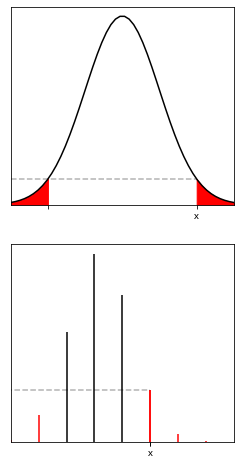

In [19]:
from helpers.crosstab_test import pvalue
pvalue.show()

$2\times 2$ 分割表の周辺度数が与えられた場合、 1 つのセルの値が定まると全体の値が決まる。

<table class="text-center border background-default">
    <tr>
        <td class="border-none" rowspan="2" colspan="2"></td>
        <td colspan="2">変数 $X$</td>
        <td class="border-bottom-bold" rowspan="2">周辺度数</td>
    </tr>
    <tr>
        <td class="border-bottom-bold" style="min-width: 14em;">カテゴリ $X_{1}$</td>
        <td class="border-bottom-bold" style="min-width: 14em;">カテゴリ $X_{2}$</td>
    </tr>
    <tr>
        <td rowspan="2">変数 $Y$</td>
        <td class="border-right-bold">カテゴリ $Y_{1}$</td>
        <td>$x$</td>
        <td>$A-x$</td>
        <td>$A$</td>
    </tr>
    <tr>
        <td class="border-right-bold">カテゴリ $Y_{2}$</td>
        <td>$C-x$</td>
        <td>$D-A+x=B-C+x$</td>
        <td>$B$</td>
    </tr>
    <tr>
        <td class="border-right-bold" colspan="2">周辺度数</td>
        <td>$C$</td>
        <td>$D$</td>
        <td>$N$</td>
    </tr>
</table>

<table class="text-center border background-default">
    <tr>
        <td class="border-none" colspan="5">具体例</td>
    </tr>
    <tr>
        <td class="border-none" rowspan="2" colspan="2"></td>
        <td colspan="2">変数 $X$</td>
        <td class="border-bottom-bold" rowspan="2">周辺度数</td>
    </tr>
    <tr>
        <td class="border-bottom-bold" style="min-width: 14em;">カテゴリ $X_{1}$</td>
        <td class="border-bottom-bold" style="min-width: 14em;">カテゴリ $X_{2}$</td>
    </tr>
    <tr>
        <td rowspan="2">変数 $Y$</td>
        <td class="border-right-bold">カテゴリ $Y_{1}$</td>
        <td>$x$</td>
        <td>$10-x$</td>
        <td>$10$</td>
    </tr>
    <tr>
        <td class="border-right-bold">カテゴリ $Y_{2}$</td>
        <td>$13-x$</td>
        <td>$1+x$</td>
        <td>$14$</td>
    </tr>
    <tr>
        <td class="border-right-bold" colspan="2">周辺度数</td>
        <td>$13$</td>
        <td>$11$</td>
        <td>$24$</td>
    </tr>
</table>

以上を利用して、サンプルである分割表よりも観測される確率が低い分割表 (片側検定の場合は対応するセルの値が大きい／小さいものに限定) の確率を合計した値を $p$ 値とする。

###### 練習問題

分割表`cross`を元にフィッシャーの正確確率検定 (両側) の $p$ 値を求める。

In [20]:
cross = pd.DataFrame([[1, 9], [11, 3]])
cross.columns.name = 'X'
cross.index.name = 'Y'
print('cross')
display(cross)

cross


X,0,1
Y,,
0,1,9
1,11,3


In [21]:
def probability(x):
    distribution = stats.hypergeom(cross.values.sum(), cross[1].sum(), cross.loc[1].sum())
    return distribution.pmf(x)

thresh = probability(cross.loc[1, 1])
probs = [probability(x) for x in range(min(cross[1].sum(), cross.loc[1].sum()))]
sum([p for p in probs if p <= thresh])

0.002725804280522283

### 補足
---
フィッシャーの正確確率検定は $2\times 2$ 分割表だけでなく、より大きな分割表でも実施できるがここでは扱わない。

### Pythonでのフィッシャーの正確確率検定の実行方法
---
`scipy.stats.fisher_exact`を使用する。

In [22]:
stats.fisher_exact??

In [23]:
stats.fisher_exact(cross)

(0.030303030303030304, 0.0027594561852200745)